In [1]:
# ============================================================
# Exercise 3 - Data Rebalancing and Cross-Validation (Enhanced)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    f1_score, roc_auc_score, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 1. Load dataset and create artificial imbalance
X, y = load_breast_cancer(return_X_y=True)
print("Class distribution (Before):", Counter(y))

# Artificial imbalance: keep fewer minority samples
idx_majority = np.where(y == 0)[0]
idx_minority = np.where(y == 1)[0]
np.random.seed(42)
idx_minority = np.random.choice(idx_minority, size=int(0.4 * len(idx_minority)), replace=False)

X = np.vstack((X[idx_majority], X[idx_minority]))
y = np.hstack((y[idx_majority], y[idx_minority]))

print("Class distribution (After):", Counter(y))

# Train/test split, with 30% for Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Class distribution (Before): Counter({1: 357, 0: 212})
Class distribution (After): Counter({0: 212, 1: 142})


In [5]:
# 2. Define rebalancing strategies
samplers = {
    "No Rebalancing": None,
    "Random OverSampling": RandomOverSampler(random_state=42),

    "Random UnderSampling": RandomUnderSampler(random_state=42)
}


In [6]:
# 3. Evaluation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
conf_matrices = {}

for name, sampler in samplers.items():
    print(f"\n=== {name} ===")

    X_res, y_res = (X_train, y_train)
    if sampler:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
    print("Class distribution after sampling:", Counter(y_res))

    model = RandomForestClassifier(n_estimators=100, random_state=42)

    f1_scores, auc_scores = [], []
    conf_sum = np.zeros((2,2))

    for train_idx, val_idx in cv.split(X_res, y_res):
        X_tr, X_val = X_res[train_idx], X_res[val_idx]
        y_tr, y_val = y_res[train_idx], y_res[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:,1]

        f1_scores.append(f1_score(y_val, y_pred))
        auc_scores.append(roc_auc_score(y_val, y_proba))
        conf_sum += confusion_matrix(y_val, y_pred)

    conf_avg = conf_sum / cv.get_n_splits()
    conf_matrices[name] = conf_avg

    results.append({
        'Method': name,
        'F1_mean': np.mean(f1_scores),
        'F1_std': np.std(f1_scores),
        'AUC_mean': np.mean(auc_scores),
        'AUC_std': np.std(auc_scores)
    })


=== No Rebalancing ===
Class distribution after sampling: Counter({0: 148, 1: 99})

=== Random OverSampling ===
Class distribution after sampling: Counter({1: 148, 0: 148})

=== Random UnderSampling ===
Class distribution after sampling: Counter({0: 99, 1: 99})


In [7]:
# 4. Compile and display results
results_df = pd.DataFrame(results)
print("\n=== Cross-Validation Results ===")
print(results_df.round(3))


=== Cross-Validation Results ===
                 Method  F1_mean  F1_std  AUC_mean  AUC_std
0        No Rebalancing    0.934   0.035     0.983    0.018
1   Random OverSampling    0.950   0.028     0.987    0.015
2  Random UnderSampling    0.930   0.051     0.980    0.027


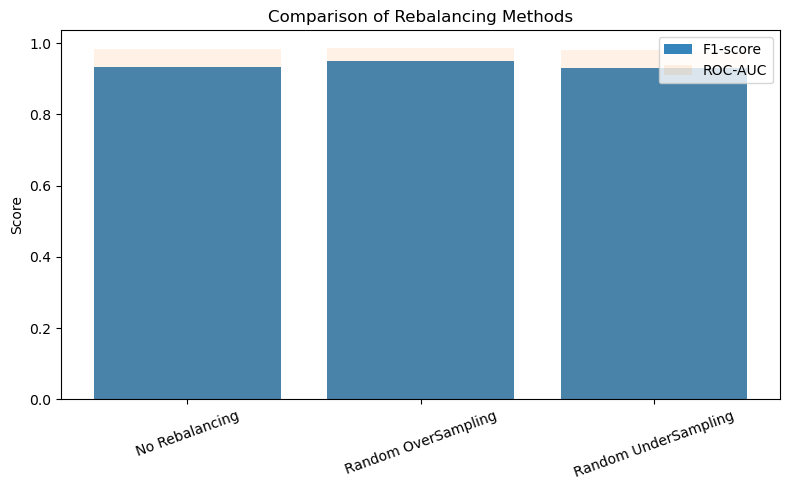

In [8]:
# 5. Plot comparison (F1 and AUC)
plt.figure(figsize=(8,5))
plt.bar(results_df['Method'], results_df['F1_mean'], alpha=0.9, label='F1-score')
plt.bar(results_df['Method'], results_df['AUC_mean'], alpha=0.1, label='ROC-AUC')
plt.title("Comparison of Rebalancing Methods")
plt.ylabel("Score")
plt.xticks(rotation=20)
plt.legend()
plt.tight_layout()
plt.show()

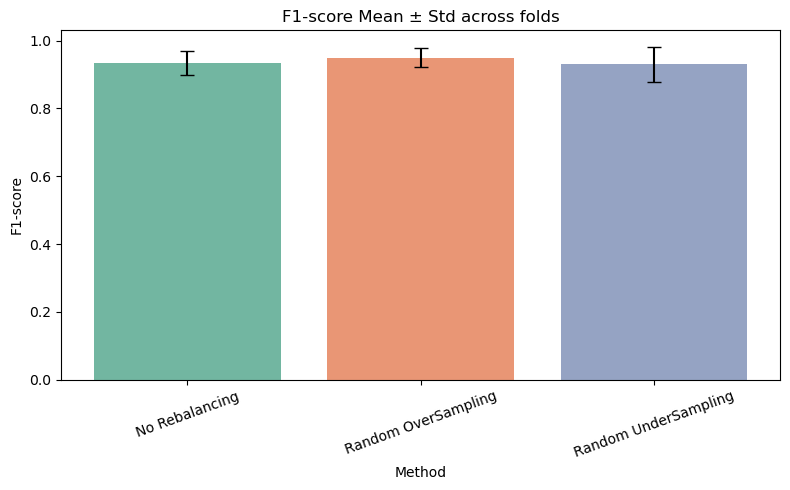

In [9]:
# 6. Plot distribution of F1-scores
plt.figure(figsize=(8,5))
sns.barplot(x="Method", y="F1_mean", hue="Method", data=results_df, palette="Set2", errorbar=None, legend=False)
plt.errorbar(x=np.arange(len(results_df)), y=results_df["F1_mean"],
             yerr=results_df["F1_std"], fmt='none', ecolor='black', capsize=5)
plt.title("F1-score Mean ± Std across folds")
plt.ylabel("F1-score")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


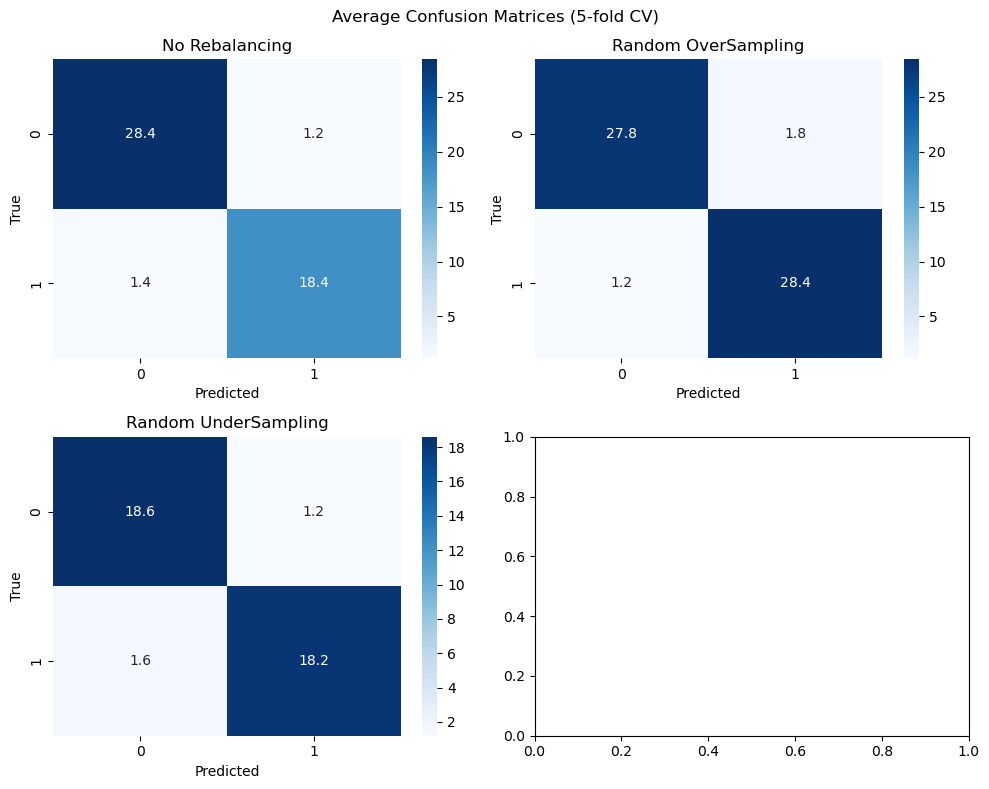

In [10]:
# 7. Visualize average confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

plt.suptitle("Average Confusion Matrices (5-fold CV)")
plt.tight_layout()
plt.show()